In [1]:
import os
import sys
sys.path.append('../sdbm/code')
sys.path.append('../DeepView/deepview')
sys.path.append('../dbm_evaluation')
# import make blobs
from sklearn.datasets import make_blobs
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as T
import torch.linalg as LA

from ssnp import SSNP
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
# import skdim

from map_evaluation import P_wrapper, MapBuilder
from ssnp import SSNP

sys.path.append('../GAN_inverse_projection')
# from utils import GANinv, CGANinv
from umap import UMAP
from LID import ID_finder_T, get_data_LID, get_eigen_general , ID_finder_np

import os

from lamp import Pinv_ilamp
from rbf_inv import RBFinv

2024-07-15 11:05:00.627878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:05:00.771857: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 11:05:00.821899: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 11:05:01.890272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:

class Simple_P_wrapper:
    def __init__(self, P, Pinv, bottleneck_dim=2):
        self.P = P
        self.Pinv = Pinv
        self.bottleneck_dim = bottleneck_dim
    def __call__(self, x):
        return self.P(x)
    def transform(self, x):
        return self.P.transform(x)
    def inverse_transform(self, x):
        return self.Pinv.transform(x)

    def fit(self, x, y=None, clf=None):
        # self.P.fit(x)
        self.X2d = self.P.fit_transform(x)
        self.Pinv.fit(self.X2d, x )
        return self

In [12]:
data_dir = '../sdbm/data'
data_dirs = [
    # 'blobs_dim3_n5000_y5',
    # 'blobs_dim10_n5000_y5',
    # 'blobs_dim30_n5000_y5',
    # 'blobs_dim100_n5000_y5',
    # 'blobs_dim300_n5000_y5',

    # 'blobs_dim3_n5000_y2',
    # 'blobs_dim10_n5000_y2',
    # 'blobs_dim30_n5000_y2',
    # 'blobs_dim100_n5000_y2',
    # 'blobs_dim300_n5000_y2',

    # 'blobs_dim3_n5000_y3',
    # 'blobs_dim10_n5000_y3',
    # 'blobs_dim30_n5000_y3',
    # 'blobs_dim100_n5000_y3',
    # 'blobs_dim300_n5000_y3',
    
    
    
    'blobs_dim10_n5000_y10',
    'blobs_dim30_n5000_y10',
    'blobs_dim100_n5000_y10',

    # 'blobs_dim30_n5000_y10',
    # 'blobs_dim60_n5000_y10',
    # 'blobs_dim90_n5000_y10',

    # # 'blobs_dim300_n1500_y10',
    #   
    'har',   
    'mnist', 
    # 'fashionmnist', 
    # 'reuters', 
    ]

datasets_real = {}

for d in data_dirs:
    dataset_name = d
    if not 'blob' in d:
        X = np.load(os.path.join(data_dir, d,  'X.npy'))
        y = np.load(os.path.join(data_dir, d, 'y.npy'))

    #blobs
    else:
        dim = int(d.split('_')[1][3:])
        print(dim)
        n_class = int(d.split('_')[3][1:])
        X, y = make_blobs(n_samples=15000, n_features=dim, centers=n_class, cluster_std=1, random_state=0)
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X).astype(np.float32)
    ######
    n_samples = X.shape[0]
    n_classes = len(np.unique(y))

    # if 'blob' in d:
    #     train_size = dim = int(d.split('_')[2][1:])
    # else:
    #     train_size = min(int(n_samples*0.9), 5000)
    train_size = 5000
    test_size = 10000 # inverse
    
    dataset =\
        train_test_split(X, y, train_size=train_size, random_state=420, stratify=y)
    datasets_real[dataset_name] = dataset
    # print(X.shape)

    ## clip dataset[1] and dataset[3] to test_size if they are larger
    if dataset[1].shape[0] > test_size:
        dataset[1] = dataset[1][:test_size]
        dataset[3] = dataset[3][:test_size]


projectors = {
    # 'UMAP+iLAMP': Simple_P_wrapper(UMAP(random_state=42), Pinv_ilamp()),
            
            'DBM': P_wrapper(NNinv_Torch=1, ),
            'SDBM' : P_wrapper(ssnp=1),
            'DeepView': P_wrapper(deepview=1),
            # 'UMAP+iLAMP': Simple_P_wrapper(UMAP(random_state=42), Pinv_ilamp()),
            # 'UMAP+RBF': Simple_P_wrapper(UMAP(random_state=42), RBFinv()),
            'MDS+iMDS': None,
            # 'DBM_orig_keras': P_wrapper(NNinv_Keras=1),
            
            # 'SSNP_3' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=3),
            # 'SSNP_10' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=10),
            # 'SSNP_30' : SSNP(patience=5, opt='adam', bottleneck_activation='linear', verbose=0, bottleneck_dim=30),
            
            # 'DBM_2' : P_wrapper(NNinv_Torch=1, bottleneck_dim=2),
            # 'DBM_5' : P_wrapper(NNinv_Torch=1, bottleneck_dim=5),
            # 'DBM_10' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10),
            # 'DBM_15' : P_wrapper(NNinv_Torch=1, bottleneck_dim=15),
            # 'DBM_20' : P_wrapper(NNinv_Torch=1, bottleneck_dim=20),

            # 'DBM_3_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=3, P='PCA'),
            # 'DBM_10_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10, P='PCA'),
            # 'DBM_30_PCA' : P_wrapper(NNinv_Torch=1, bottleneck_dim=30, P='PCA'),

            # 'DBM_3_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=3, P='tSNE'),
            # 'DBM_10_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=10, P='tSNE'),
            # 'DBM_30_tSNE' : P_wrapper(NNinv_Torch=1, bottleneck_dim=30, P='tSNE'),
            }

10
30
100


In [5]:
save_dir = './LID_results_new_grid500_GM'

mnist = os.path.join(save_dir, 'mnist_MDS+iMDS.npz')
har = os.path.join(save_dir, 'har_MDS+iMDS.npz')

In [6]:
X2d_mnist = np.load(mnist)['X_train_2d']
X2d_har = np.load(har)['X_train_2d']

y_mnist = np.load(mnist)['y_train']
y_har = np.load(har)['y_train']

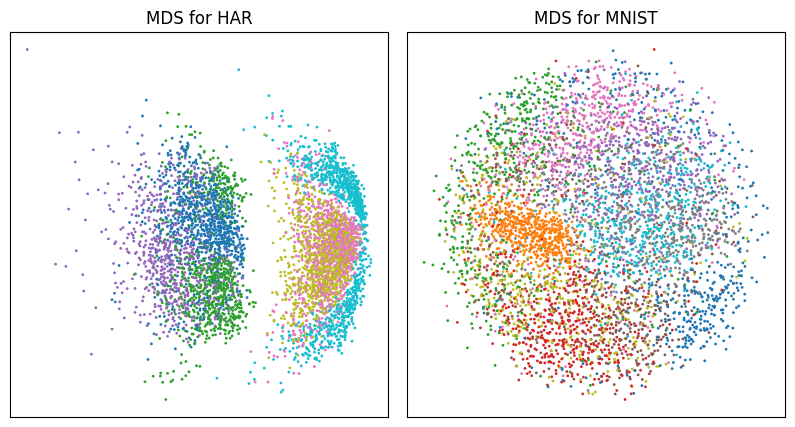

In [48]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.05)
ax1.scatter(X2d_mnist[:, 0], X2d_mnist[:, 1], c=y_mnist, cmap='tab10', s=1)
ax1.set_title('MDS for MNIST')
# ax1.set_aspect('equal', 'box')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.scatter(X2d_har[:, 0], X2d_har[:, 1], c=y_har, cmap='tab10', s=1)
ax2.set_title('MDS for HAR')

# ax2.set_aspect('equal')
ax2.set_xticks([])
ax2.set_yticks([])
fig.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/MDS_HAR_MNIST.png', dpi=300, bbox_inches='tight')

DBM
SDBM
DeepView
MDS+iMDS


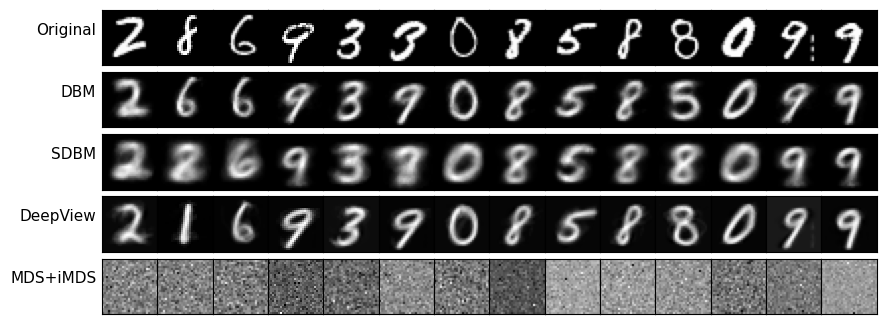

In [38]:
size = 14
fig, axes = plt.subplots(5, size, figsize=(10, 4))
# wspace
fig.subplots_adjust(wspace=0., hspace=0.05)

X_train = np.load(mnist)['X_train']
#randomly select 10 samples
idx = np.random.choice(X_train.shape[0], size)
for i in range(size):
    axes[0, i].imshow(X_train[idx[i]].reshape(28, 28), cmap='gray')
    # axes[0, i].axis('off')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
axes[0, 0].set_ylabel('Original', fontsize=11, rotation=0, horizontalalignment='right')

for i, (name, projector) in enumerate(projectors.items()):
    print(name)
    X_recon = np.load(os.path.join(save_dir, 'mnist_'+name+'.npz'))['X_recon']
    for j in range(size):
        axes[i+1, j].imshow(X_recon[idx[j]].reshape(28, 28), cmap='gray')
        axes[i+1, j].set_xticks([])
        axes[i+1, j].set_yticks([])
    axes[i+1, 0].set_ylabel(name, fontsize=11, rotation=0, horizontalalignment='right')
    

In [39]:
fig.savefig('../paper/IVAPP24_extend_CCIS/figures/figure_CCIS/mnist_rec.png', dpi=300, bbox_inches='tight')